<a href="https://colab.research.google.com/github/milvus-io/bootcamp/blob/master/integration/evaluation_with_contextual_ai_lmunit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<a href="https://github.com/milvus-io/bootcamp/blob/master/integration/evaluation_with_contextual_ai_lmunit.ipynb" target="_blank">
    <img src="https://img.shields.io/badge/View%20on%20GitHub-555555?style=flat&logo=github&logoColor=white" alt="GitHub Repository"/>
</a>


# Evaluation with Contextual AI LMUnit

**Versions used:**
- Milvus version `1.3.4`
- Contextual AI client `0.9.0`

This guide demonstrates how to use [Contextual AI's LMUnit](https://docs.contextual.ai/api-reference/lmunit/lmunit?utm_campaign=lmunit-integration&utm_source=milvus&utm_medium=github&utm_content=notebook) to evaluate a Retrieval-Augmented Generation (RAG) pipeline built upon [Milvus](https://milvus.io/).

The RAG system combines a retrieval system with a generative model to generate new text based on a given prompt. The system first retrieves relevant documents from a corpus using Milvus, and then uses a generative model to generate new text based on the retrieved documents.

[LMUnit](https://contextual.ai/research/lmunit?utm_campaign=lmunit-integration&utm_source=milvus&utm_medium=github&utm_content=notebook) is a specialized model developed by Contextual AI for evaluating LLM response quality through natural language unit testing. It achieves state-of-the-art performance in assessing generative AI outputs by providing a structured method to test responses.

**Key Features:**
- **RAG Pipeline Evaluation**: Test complete Chroma + LLM RAG systems
- **Natural Language Unit Testing**: Systematic evaluation of response quality
- **Domain-Specific Testing**: Custom unit tests for different use cases
- **Visualization & Analysis**: Comprehensive evaluation results analysis

### Why Natural Language Unit Testing for RAG?

Traditional RAG evaluation methods often face several challenges:
- **Retrieval Quality**: Hard to measure if retrieved documents are relevant
- **Generation Quality**: LLM responses may be factually incorrect or poorly structured
- **End-to-End Evaluation**: Difficult to assess the complete RAG pipeline
- **Domain-Specific Requirements**: Generic metrics don't capture domain nuances

Natural language unit tests address these challenges by:
- **Breaking down evaluation** into specific, testable criteria
- **Providing granular feedback** on different quality aspects
- **Enabling systematic improvement** of RAG systems
- **Supporting domain-specific** quality requirements

**Open Source Alternative**: For users who want to host LMUnit themselves, we provide an open source version available on [Hugging Face](https://huggingface.co/collections/ContextualAI/lmunit).



## Prerequisites

Before running this notebook, make sure you have the following dependencies installed:

**Important**: We install `pymilvus[milvus_lite]` to enable local Milvus database connections. The `[milvus_lite]` extra is required for using Milvus Lite.


In [ ]:
! pip install --upgrade "pymilvus[milvus_lite]" contextual-client openai requests tqdm pandas matplotlib seaborn scikit-learn


> If you are using Google Colab, to enable dependencies just installed, you may need to **restart the runtime** (click on the "Runtime" menu at the top of the screen, and select "Restart session" from the dropdown menu).

You will need API keys for both Contextual AI and OpenAI:
- [Contextual AI API key](https://docs.contextual.ai/user-guides/beginner-guide?utm_campaign=lmunit-integration&utm_source=milvus&utm_medium=github&utm_content=notebook) for LMUnit evaluation
- [OpenAI API key](https://platform.openai.com/docs/quickstart) for the RAG pipeline


In [ ]:
import os

os.environ["CONTEXTUAL_API_KEY"] = "key-4-..."
os.environ["OPENAI_API_KEY"] = "sk-proj-..."


## Define the RAG Pipeline

We will define a RAG class that uses Milvus as the vector store and OpenAI as the LLM. The class contains the `load` method, which loads text data into Milvus, the `retrieve` method, which retrieves the most similar text data to the given question, and the `answer` method, which answers the given question with the retrieved knowledge.


In [3]:
from typing import List
from pymilvus import MilvusClient
from openai import OpenAI
import numpy as np

class RAGPipeline:
    def __init__(self, collection_name: str = "evaluation_collection"):
        self.milvus_client = MilvusClient(uri="./milvus_evaluation.db")
        self.openai_client = OpenAI()
        self.collection_name = collection_name

    def emb_text(self, text: str) -> List[float]:
        """Generate embeddings using OpenAI"""
        return (
            self.openai_client.embeddings.create(
                input=text, model="text-embedding-3-small"
            )
            .data[0]
            .embedding
        )

    def load(self, texts: List[str]):
        """Load texts into Milvus collection"""
        # Create collection if it doesn't exist
        if self.milvus_client.has_collection(self.collection_name):
            self.milvus_client.drop_collection(self.collection_name)

        # Get embedding dimension
        test_embedding = self.emb_text("test")
        embedding_dim = len(test_embedding)

        self.milvus_client.create_collection(
            collection_name=self.collection_name,
            dimension=embedding_dim,
            metric_type="IP",
            consistency_level="Bounded",
        )

        # Insert data
        data = []
        for i, text in enumerate(texts):
            embedding = self.emb_text(text)
            data.append({"id": i, "vector": embedding, "text": text})

        self.milvus_client.insert(collection_name=self.collection_name, data=data)
        print(f"Loaded {len(texts)} documents into Milvus")

    def retrieve(self, question: str, top_k: int = 3) -> List[str]:
        """Retrieve relevant documents for a question"""
        search_res = self.milvus_client.search(
            collection_name=self.collection_name,
            data=[self.emb_text(question)],
            limit=top_k,
            search_params={"metric_type": "IP", "params": {}},
            output_fields=["text"],
        )

        return [res["entity"]["text"] for res in search_res[0]]

    def answer(self, question: str, top_k: int = 3) -> str:
        """Generate answer using retrieved context"""
        context = self.retrieve(question, top_k)
        context_str = "\n".join(context)

        response = self.openai_client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant. Answer the question based on the provided context. If the context doesn't contain enough information, say so."
                },
                {
                    "role": "user",
                    "content": f"Context:\n{context_str}\n\nQuestion: {question}"
                }
            ],
            temperature=0.1
        )

        return response.choices[0].message.content


## Load Sample Data

We'll use a sample dataset of financial documents to demonstrate LMUnit evaluation:


In [4]:
# Sample financial documents for evaluation
sample_documents = [
    "The Federal Reserve raised interest rates by 0.25% to combat inflation. This marks the third consecutive rate increase this year, bringing the federal funds rate to 5.25%.",
    "Apple Inc. reported record quarterly revenue of $94.8 billion, driven by strong iPhone sales and services growth. The company's stock price increased by 8% following the earnings announcement.",
    "The Consumer Price Index (CPI) rose 3.2% year-over-year in October, slightly below expectations. Core inflation, excluding food and energy, increased by 4.0%.",
    "Tesla's autonomous driving technology has received regulatory approval in California. The company plans to roll out Full Self-Driving (FSD) features to all eligible vehicles by Q2 2024.",
    "The European Central Bank maintained its key interest rate at 4.5% while signaling potential future cuts if inflation continues to decline. The euro strengthened against the dollar following the announcement."
]

# Sample questions and expected answers for evaluation
evaluation_data = [
    {
        "question": "What is the current federal funds rate?",
        "expected_answer": "The federal funds rate is currently 5.25% after the Federal Reserve raised it by 0.25%."
    },
    {
        "question": "How much revenue did Apple report in their latest quarter?",
        "expected_answer": "Apple reported record quarterly revenue of $94.8 billion in their latest quarter."
    },
    {
        "question": "What was the year-over-year CPI increase in October?",
        "expected_answer": "The Consumer Price Index (CPI) rose 3.2% year-over-year in October."
    }
]

# Initialize and load data into RAG pipeline
rag = RAGPipeline()
rag.load(sample_documents)


Loaded 5 documents into Milvus


## Set Up LMUnit Evaluation

Now we'll set up LMUnit for evaluating our RAG pipeline responses:


In [5]:
from contextual import ContextualAI
import pandas as pd
from tqdm import tqdm

# Initialize Contextual AI client
contextual_client = ContextualAI(api_key=os.environ["CONTEXTUAL_API_KEY"])

# Define unit tests for financial domain evaluation
unit_tests = [
    "Does the response provide specific numerical data when available?",
    "Is the response factually accurate based on the provided context?",
    "Does the response avoid speculation or unsupported claims?",
    "Is the response clear and well-structured?",
    "Does the response directly answer the question asked?"
]

def run_lmunit_evaluation(rag_pipeline, evaluation_data, unit_tests):
    """Run LMUnit evaluation on RAG pipeline responses"""
    results = []

    for item in tqdm(evaluation_data, desc="Evaluating responses"):
        question = item["question"]
        expected_answer = item["expected_answer"]

        # Generate response using RAG pipeline
        generated_response = rag_pipeline.answer(question)

        # Run unit tests on the generated response
        test_results = []
        for test in unit_tests:
            try:
                result = contextual_client.lmunit.create(
                    query=question,
                    response=generated_response,
                    unit_test=test
                )
                test_results.append({
                    'test': test,
                    'score': result.score,
                    'metadata': result.metadata if hasattr(result, 'metadata') else None
                })
            except Exception as e:
                print(f"Error with test '{test}': {e}")
                test_results.append({
                    'test': test,
                    'score': None,
                    'error': str(e)
                })

        results.append({
            'question': question,
            'expected_answer': expected_answer,
            'generated_response': generated_response,
            'test_results': test_results
        })

    return results

# Run evaluation
evaluation_results = run_lmunit_evaluation(rag, evaluation_data, unit_tests)


Evaluating responses: 100%|██████████| 3/3 [00:26<00:00,  8.77s/it]


## Analyze Results

Let's analyze the evaluation results and visualize the performance:


Average Scores by Test:
                                          test      mean       std  count
2  Does the response provide specific numer...  4.843000  0.051856      3
3  Is the response clear and well-structure...  4.782333  0.038188      3
1  Does the response directly answer the qu...  4.529667  0.073596      3
0  Does the response avoid speculation or u...  3.079000  0.408490      3
4  Is the response factually accurate based...  2.012333  0.067092      3


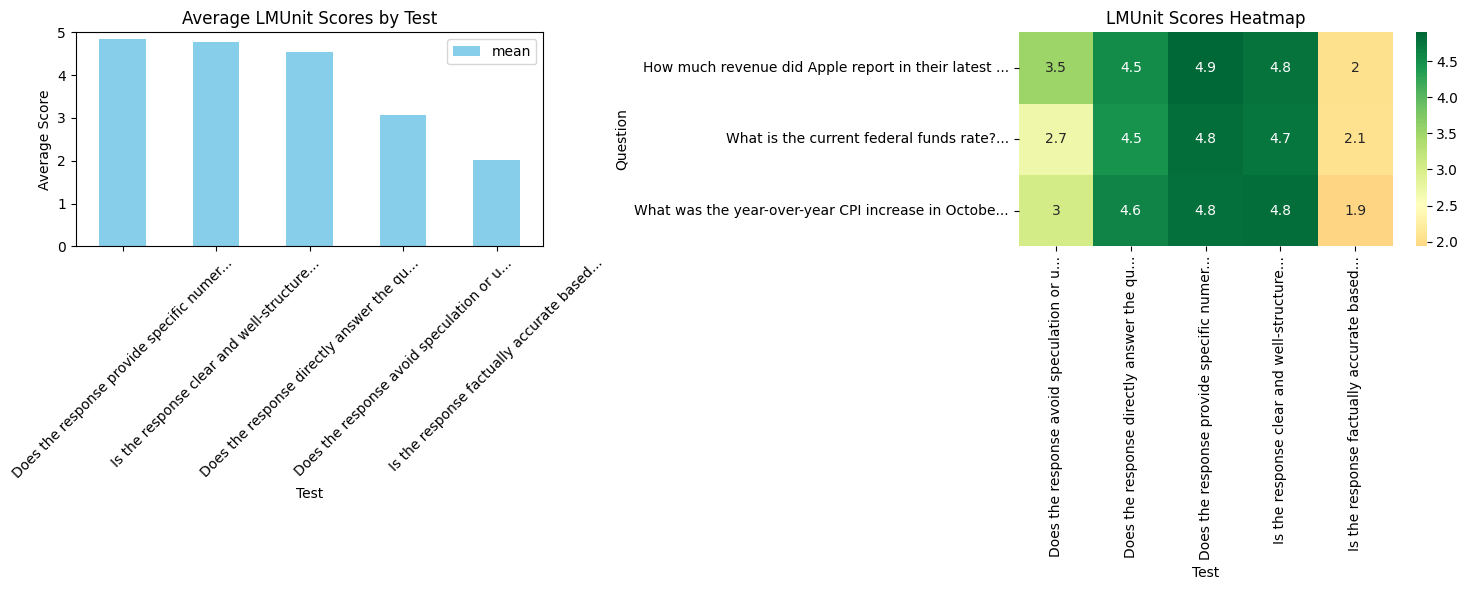

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Process results for analysis
analysis_data = []
for result in evaluation_results:
    for test_result in result['test_results']:
        if test_result['score'] is not None:
            analysis_data.append({
                'question': result['question'][:50] + "...",  # Truncate for display
                'test': test_result['test'][:40] + "...",  # Truncate for display
                'score': test_result['score']
            })

# Create DataFrame for analysis
df = pd.DataFrame(analysis_data)

# Calculate average scores by test
test_scores = df.groupby('test')['score'].agg(['mean', 'std', 'count']).reset_index()
test_scores = test_scores.sort_values('mean', ascending=False)

print("Average Scores by Test:")
print(test_scores)

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of average scores by test
test_scores.plot(x='test', y='mean', kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Average LMUnit Scores by Test')
ax1.set_xlabel('Test')
ax1.set_ylabel('Average Score')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 5)

# Heatmap of scores by question and test
pivot_df = df.pivot(index='question', columns='test', values='score')
sns.heatmap(pivot_df, annot=True, cmap='RdYlGn', center=2.5, ax=ax2)
ax2.set_title('LMUnit Scores Heatmap')
ax2.set_xlabel('Test')
ax2.set_ylabel('Question')

plt.tight_layout()
plt.show()


## Advanced Evaluation with Custom Scoring Rubrics

LMUnit supports custom scoring rubrics for more detailed evaluation:


In [7]:
# Advanced evaluation with custom scoring rubric
advanced_unit_test = """
Does the response provide comprehensive financial information?
Scoring Scale:
Score 1: No specific financial data provided; vague or general statements only
Score 2: Limited financial data provided; either numbers or context discussed, but not both
Score 3: Basic financial data provided with surface-level analysis
Score 4: Clear financial data provided with detailed analysis and context
Score 5: Comprehensive financial data with in-depth analysis, context, and implications
"""

# Run advanced evaluation
advanced_results = []
for item in evaluation_data:
    question = item["question"]
    generated_response = rag.answer(question)

    try:
        result = contextual_client.lmunit.create(
            query=question,
            response=generated_response,
            unit_test=advanced_unit_test
        )
        advanced_results.append({
            'question': question,
            'response': generated_response,
            'score': result.score,
            'metadata': result.metadata if hasattr(result, 'metadata') else None
        })
    except Exception as e:
        print(f"Error with advanced evaluation: {e}")

# Display advanced results
print("Advanced Evaluation Results:")
for result in advanced_results:
    print(f"\nQuestion: {result['question']}")
    print(f"Score: {result['score']}/5")
    print(f"Response: {result['response'][:200]}...")


Advanced Evaluation Results:

Question: What is the current federal funds rate?
Score: 1.88/5
Response: The current federal funds rate is 5.25%....

Question: How much revenue did Apple report in their latest quarter?
Score: 1.971/5
Response: Apple reported record quarterly revenue of $94.8 billion....

Question: What was the year-over-year CPI increase in October?
Score: 1.982/5
Response: The year-over-year CPI increase in October was 3.2%....


## Performance Analysis and Insights

Let's analyze the overall performance and identify areas for improvement:


In [8]:
# Calculate overall statistics
all_scores = [score for result in evaluation_results for test_result in result['test_results']
              if test_result['score'] is not None for score in [test_result['score']]]

if all_scores:
    print(f"Overall Performance Statistics:")
    print(f"Average Score: {np.mean(all_scores):.2f}")
    print(f"Median Score: {np.median(all_scores):.2f}")
    print(f"Standard Deviation: {np.std(all_scores):.2f}")
    print(f"Min Score: {np.min(all_scores):.2f}")
    print(f"Max Score: {np.max(all_scores):.2f}")

    # Identify low-performing areas
    low_scores = [score for score in all_scores if score < 3.0]
    print(f"\nLow Scores (< 3.0): {len(low_scores)} out of {len(all_scores)} ({len(low_scores)/len(all_scores)*100:.1f}%)")

    # Performance by test type
    print(f"\nPerformance by Test Type:")
    for test in unit_tests:
        test_scores = [test_result['score'] for result in evaluation_results
                      for test_result in result['test_results']
                      if test_result['test'] == test and test_result['score'] is not None]
        if test_scores:
            avg_score = np.mean(test_scores)
            print(f"  {test[:50]}...: {avg_score:.2f}")

# Display detailed results
print(f"\nDetailed Evaluation Results:")
for i, result in enumerate(evaluation_results):
    print(f"\n--- Evaluation {i+1} ---")
    print(f"Question: {result['question']}")
    print(f"Generated Response: {result['generated_response']}")
    print(f"Test Scores:")
    for test_result in result['test_results']:
        if test_result['score'] is not None:
            print(f"  - {test_result['test'][:50]}...: {test_result['score']}/5")
        else:
            print(f"  - {test_result['test'][:50]}...: Error - {test_result.get('error', 'Unknown error')}")


Overall Performance Statistics:
Average Score: 3.85
Median Score: 4.53
Standard Deviation: 1.13
Min Score: 1.94
Max Score: 4.90

Low Scores (< 3.0): 4 out of 15 (26.7%)

Performance by Test Type:
  Does the response provide specific numerical data ...: 4.84
  Is the response factually accurate based on the pr...: 2.01
  Does the response avoid speculation or unsupported...: 3.08
  Is the response clear and well-structured?...: 4.78
  Does the response directly answer the question ask...: 4.53

Detailed Evaluation Results:

--- Evaluation 1 ---
Question: What is the current federal funds rate?
Generated Response: The current federal funds rate is 5.25%.
Test Scores:
  - Does the response provide specific numerical data ...: 4.836/5
  - Is the response factually accurate based on the pr...: 2.055/5
  - Does the response avoid speculation or unsupported...: 2.699/5
  - Is the response clear and well-structured?...: 4.749/5
  - Does the response directly answer the question ask...: 4.454/5

## Summary

This guide demonstrated how to use Contextual AI's LMUnit to evaluate a RAG pipeline built with Milvus. Key takeaways:

### LMUnit Advantages:
- **Natural Language Unit Testing**: Provides structured, testable criteria for LLM responses
- **Granular Feedback**: Breaks down evaluation into specific quality aspects
- **Domain-Specific Evaluation**: Supports custom scoring rubrics for specialized domains
- **State-of-the-Art Performance**: Achieves superior evaluation accuracy compared to traditional methods

### Evaluation Workflow:
1. **Setup**: Initialize RAG pipeline with Milvus and OpenAI
2. **Data Loading**: Load sample documents into vector database
3. **Response Generation**: Generate responses using RAG pipeline
4. **Unit Testing**: Apply LMUnit tests to evaluate response quality
5. **Analysis**: Visualize and analyze evaluation results
6. **Improvement**: Identify areas for RAG pipeline enhancement

### Key Benefits:
- **Systematic Evaluation**: Structured approach to assessing LLM output quality
- **Actionable Insights**: Detailed feedback for improving RAG performance
- **Scalable Testing**: Easy to add new test cases and evaluation criteria
- **Production Ready**: Robust evaluation framework for real-world applications

### Next Steps:
- Experiment with different unit test designs for your specific domain
- Integrate LMUnit evaluation into your RAG pipeline development workflow
- Use evaluation results to fine-tune retrieval and generation parameters
- Implement continuous evaluation monitoring for production RAG systems

This evaluation framework provides a solid foundation for building high-quality, reliable RAG applications with Milvus and Contextual AI.
